In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PoissonRegressor
from sklearn.linear_model import PoissonRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
import sklearn.linear_model
from seaborn import set_style
set_style("whitegrid")
import csv
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_poisson_deviance as mpd
import warnings
warnings.filterwarnings("ignore")

In [3]:
#Import the data
rec = pd.read_csv('NFLRecords.csv')
totalpicks = pd.read_csv('draftpicks.csv')
totalcombine_data = pd.read_csv('Data_Bowl_Combine.csv')
#Truncate data to the appropriate years
combine_data=totalcombine_data.loc[totalcombine_data['Year']%3!=0]
picks=totalpicks.loc[totalpicks['Year']%3!=0]
testcombine=totalcombine_data.loc[totalcombine_data['Year']%3==0]
testpicks=totalpicks.loc[totalpicks['Year']%3==0]
#picks=picks.truncate(after=4079)

In [4]:
#Input 0 for anamolous DrAV values
picks['DrAV'].fillna(0)
for pick in picks.index:
    if picks.loc[pick,'DrAV']<0:
        picks.loc[pick,'DrAV']=0 

In [5]:
#Combine positions usually considered roughly equivalent
new = 'C', 'G', 'OG', 'OL', 'OT'
combine_data['Pos'] = combine_data['Pos'].replace(new, 'OL')
combine_data['Pos'].nunique()


new = 'FS', 'SS', 'S', 'DB', 'CB'
combine_data['Pos'] = combine_data['Pos'].replace(new, 'DB')
combine_data['Pos'].nunique()


new = 'TE', 'FB'
combine_data['Pos'] = combine_data['Pos'].replace(new, 'TE')
combine_data['Pos'].nunique()

new = 'NT', 'DL', 'DT'
combine_data['Pos'] = combine_data['Pos'].replace(new, 'DT')
combine_data['Pos'].nunique()


new = 'LB', 'OLB', 'ILB'
combine_data['Pos'] = combine_data['Pos'].replace(new, 'LB')
combine_data['Pos'].nunique()


new = 'EDGE'
combine_data['Pos'] = combine_data['Pos'].replace(new, 'DE')
combine_data['Pos'].nunique()


#Remove K, P, LS
new = 'K' , 'P' , 'LS'
combine_data = combine_data[~combine_data['Pos'].isin(new)]
combine_data['Pos'].nunique()


9

In [6]:
#Remove UDFAs and check how much data is missing.
no_UDFAs = combine_data[~combine_data['Pick'].isna()]
missing_no_UDFAs = no_UDFAs.isna().sum()
missing_no_UDFAs = missing_no_UDFAs/len(no_UDFAs) * 100
print(missing_no_UDFAs)

Player        0.000000
Pos           0.000000
Ht            0.000000
Wt            0.000000
Forty         4.471404
Vertical     19.722704
BenchReps    29.116118
BroadJump    20.970537
Cone         33.795494
Shuttle      33.136915
Team          0.000000
Round         0.000000
Pick          0.000000
Year          0.000000
Pfr_ID        1.663778
dtype: float64


In [7]:
#Add statistics to the data set.
no_UDFAs['DrAV']=[picks.loc[(picks['Tm']==no_UDFAs.loc[pick,'Team'])& (picks['Pick']==no_UDFAs.loc[pick,'Pick']), 'DrAV'].mean() for pick in no_UDFAs.index]
#These statistics ended up not being predictable based on combine data.
#no_UDFAs['SRS0']=[rec.loc[(rec['Tm']==no_UDFAs.loc[pick,'Team'])& (rec['Year']==no_UDFAs.loc[pick,'Year']-1), 'SRS'].mean() for pick in no_UDFAs.index]
#no_UDFAs['SRSAv']=[rec.loc[(rec['Tm']==no_UDFAs.loc[pick,'Team'])& (rec['Year']>=no_UDFAs.loc[pick,'Year']) & (rec['Year']<=no_UDFAs.loc[pick,'Year']+3), 'SRS'].mean() for pick in no_UDFAs.index]
#no_UDFAs['OSRS0']=[rec.loc[(rec['Tm']==no_UDFAs.loc[pick,'Team'])& (rec['Year']==no_UDFAs.loc[pick,'Year']-1), 'OSRS'].mean() for pick in no_UDFAs.index]
#no_UDFAs['OSRSAv']=[rec.loc[(rec['Tm']==no_UDFAs.loc[pick,'Team'])& (rec['Year']>=no_UDFAs.loc[pick,'Year']) & (rec['Year']<=no_UDFAs.loc[pick,'Year']+3), 'OSRS'].mean() for pick in no_UDFAs.index]
#no_UDFAs['DSRS0']=[rec.loc[(rec['Tm']==no_UDFAs.loc[pick,'Team'])& (rec['Year']==no_UDFAs.loc[pick,'Year']-1), 'DSRS'].mean() for pick in no_UDFAs.index]
#no_UDFAs['DSRSAv']=[rec.loc[(rec['Tm']==no_UDFAs.loc[pick,'Team'])& (rec['Year']>=no_UDFAs.loc[pick,'Year']) & (rec['Year']<=no_UDFAs.loc[pick,'Year']+3), 'DSRS'].mean() for pick in no_UDFAs.index]

In [8]:
new = 'C', 'G', 'OG', 'OL', 'OT'
testcombine['Pos'] = testcombine['Pos'].replace(new, 'OL')
new = 'FS', 'SS', 'S', 'DB', 'CB'
testcombine['Pos'] = testcombine['Pos'].replace(new, 'DB')
new = 'TE', 'FB'
testcombine['Pos'] = testcombine['Pos'].replace(new, 'TE')
new = 'NT', 'DL', 'DT'
testcombine['Pos'] = testcombine['Pos'].replace(new, 'DT')
new = 'LB', 'OLB', 'ILB'
testcombine['Pos'] = testcombine['Pos'].replace(new, 'LB')
new = 'EDGE'
testcombine['Pos'] = testcombine['Pos'].replace(new, 'DE')
new = 'K' , 'P' , 'LS'
testcombine = testcombine[~testcombine['Pos'].isin(new)]


In [12]:
#We will estimate how much an individual draft pick is worth.
#I use a PoissonRegressor due to the right skew of the distribution.
dravreg=PoissonRegressor(alpha=0)
#The value of k and the exponent 0.5 were chosen via hyperparameter tuning 
k=180.01
draftpick=np.array([[(i+k)**(-0.5)] for i in range(1,257)])
picks['inv']=(picks['Pick']+k)**(-0.5)
dravreg.fit( picks[['inv']],picks['DrAV'])

PoissonRegressor(alpha=0)

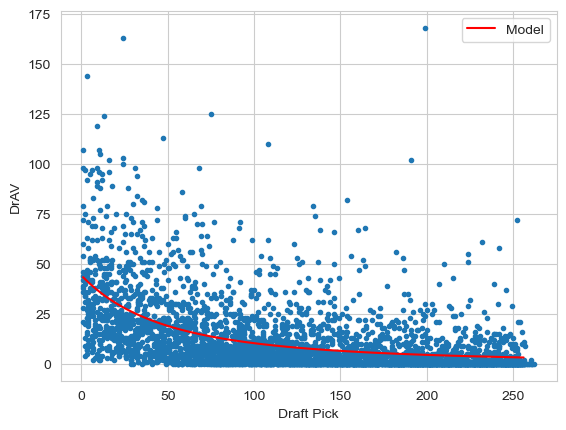

In [13]:
plt.scatter(picks['Pick'],picks['DrAV'],marker='.')
plt.plot(range(1,257),dravreg.predict(draftpick),color='red', label='Model')
plt.xlabel('Draft Pick')
plt.ylabel('DrAV')
plt.legend();

In [14]:
#An adjusted measure of the draft pick based on the previous model.

no_UDFAs['inv']=(no_UDFAs['Pick']+k)**(-0.5)

In [15]:
testno_UDFAs = testcombine[~testcombine['Pick'].isna()]
testno_UDFAs['DrAV']=[testpicks.loc[(testpicks['Tm']==testno_UDFAs.loc[pick,'Team'])& (testpicks['Pick']==testno_UDFAs.loc[pick,'Pick']), 'DrAV'].mean() for pick in testno_UDFAs.index]
scale=no_UDFAs['DrAV'].mean()/testno_UDFAs['DrAV'].mean()
testno_UDFAs['adDrAV']=testno_UDFAs['DrAV']*scale
testno_UDFAs['inv']=(testno_UDFAs['Pick']+k)**(-0.5)

In [16]:
#A sanity check statistic; the average value of each position.
for Pos in ["QB", "RB", "WR","TE","OL","DE","DT","LB","DB"]:
    print("The average DrAV of a "+Pos+" is " + str(no_UDFAs.loc[no_UDFAs['Pos']==Pos, 'DrAV'].mean()))

The average DrAV of a QB is 19.049549549549546
The average DrAV of a RB is 13.71448087431694
The average DrAV of a WR is 11.680909863945576
The average DrAV of a TE is 7.133802816901408
The average DrAV of a OL is 16.136942675159236
The average DrAV of a DE is 16.047619047619047
The average DrAV of a DT is 12.955533596837945
The average DrAV of a LB is 14.706521739130435
The average DrAV of a DB is 11.252992220227409


We note that based on current NFL salaries this does not match teams valuation of the positions. This may cause error when comparing players from different positions using this metric.

In [17]:
#Filter the desired position
#QB=no_UDFAs[no_UDFAs['Pos']=='QB']
#Interpolate blank values
#QB=QB.fillna(value=QB.loc[:,['Forty','Vertical','BenchReps','BroadJump','Cone','Shuttle']].mean())
#Model for the DrAV of a QB as a function of draft pick.
#QBmodelAv=PoissonRegressor(alpha=0,max_iter=10000)
#QBmodelAv.fit(QB[['inv']],QB['DrAV'])
#The main model predicting player performance based on combine data, the features were chosen by hyperparameter tuning.
#I used the full training set for the optimal model.
#QBmodel=LinearRegression()
#QBmodel.fit(QB[['Ht','Wt','Forty','Vertical','BenchReps','BroadJump','Cone','Shuttle']],QB['DrAV'])
#print(QBmodel.coef_)

In [20]:
QB=no_UDFAs[no_UDFAs['Pos']=='QB']
QBsc = StandardScaler()
QBsc.fit(QB[['Ht','Wt','Forty','Vertical','BenchReps','BroadJump','Cone','Shuttle']])
QB=QB.fillna(value=QB.loc[:,['Forty','Vertical','BenchReps','BroadJump','Cone','Shuttle']].mean())
QB[['AdHt','AdWt','AdForty','AdVertical','AdBenchReps','AdBroadJump','AdCone','AdShuttle']]=QBsc.transform(QB[['Ht','Wt','Forty','Vertical','BenchReps','BroadJump','Cone','Shuttle']])
QBmodelAv=PoissonRegressor(alpha=0,max_iter=10000)
QBmodelAv.fit(QB[['inv']],QB['DrAV'])
QBmodel=KNeighborsRegressor(30)
QBmodel.fit(QB[['AdHt','AdWt','AdForty','AdVertical','AdBenchReps','AdBroadJump','AdCone','AdShuttle']],QB['inv'])
print(mse(QBmodel.predict(QB[['AdHt','AdWt','AdForty','AdVertical','AdBenchReps','AdBroadJump','AdCone','AdShuttle']]),QB['inv']))
print(np.var(QB['inv']))
TestQB=testno_UDFAs[testno_UDFAs['Pos']=='QB']
TestQB=TestQB.fillna(value=QB.loc[:,['Forty','Vertical','BenchReps','BroadJump','Cone','Shuttle']].mean())
TestQB[['AdHt','AdWt','AdForty','AdVertical','AdBenchReps','AdBroadJump','AdCone','AdShuttle']]=QBsc.transform(TestQB[['Ht','Wt','Forty','Vertical','BenchReps','BroadJump','Cone','Shuttle']])
print(mse(QBmodel.predict(TestQB[['AdHt','AdWt','AdForty','AdVertical','AdBenchReps','AdBroadJump','AdCone','AdShuttle']]),TestQB['inv']))
TestQB['mean']=[no_UDFAs.loc[no_UDFAs['Pos']=='QB', 'inv'].mean() for i in TestQB.index]
print(mse(TestQB['mean'],TestQB['inv']))

6.363538418415837e-05
7.77128483742765e-05
7.158787851751285e-05
7.148414987958966e-05


In [21]:
RB=no_UDFAs[no_UDFAs['Pos']=='RB']
RBsc = StandardScaler()
RBsc.fit(RB[['Ht','Wt','Forty','Vertical','BenchReps','BroadJump','Cone','Shuttle']])
RB=RB.fillna(value=RB.loc[:,['Forty','Vertical','BenchReps','BroadJump','Cone','Shuttle']].mean())
RB[['AdHt','AdWt','AdForty','AdVertical','AdBenchReps','AdBroadJump','AdCone','AdShuttle']]=RBsc.transform(RB[['Ht','Wt','Forty','Vertical','BenchReps','BroadJump','Cone','Shuttle']])
RBmodelAv=PoissonRegressor(alpha=0,max_iter=10000)
RBmodelAv.fit(RB[['inv']],RB['DrAV'])
RBmodel=KNeighborsRegressor(30)
RBmodel.fit(RB[['AdHt','AdWt','AdForty','AdVertical','AdBenchReps','AdBroadJump','AdCone','AdShuttle']],RB['inv'])
print(mse(RBmodel.predict(RB[['AdHt','AdWt','AdForty','AdVertical','AdBenchReps','AdBroadJump','AdCone','AdShuttle']]),RB['inv']))
print(np.var(RB['inv']))
TestRB=testno_UDFAs[testno_UDFAs['Pos']=='RB']
TestRB=TestRB.fillna(value=RB.loc[:,['Forty','Vertical','BenchReps','BroadJump','Cone','Shuttle']].mean())
TestRB[['AdHt','AdWt','AdForty','AdVertical','AdBenchReps','AdBroadJump','AdCone','AdShuttle']]=RBsc.transform(TestRB[['Ht','Wt','Forty','Vertical','BenchReps','BroadJump','Cone','Shuttle']])
print(mse(RBmodel.predict(TestRB[['AdHt','AdWt','AdForty','AdVertical','AdBenchReps','AdBroadJump','AdCone','AdShuttle']]),TestRB['inv']))
TestRB['mean']=[no_UDFAs.loc[no_UDFAs['Pos']=='RB', 'inv'].mean() for i in TestRB.index]
print(mse(TestRB['mean'],TestRB['inv']))

4.569687179427506e-05
5.259609986804044e-05
4.005044819882185e-05
4.936964759338188e-05


In [22]:
TE=no_UDFAs[no_UDFAs['Pos']=='TE']
TEsc = StandardScaler()
TEsc.fit(TE[['Ht','Wt','Forty','Vertical','BenchReps','BroadJump','Cone','Shuttle']])
TE=TE.fillna(value=TE.loc[:,['Forty','Vertical','BenchReps','BroadJump','Cone','Shuttle']].mean())
TE[['AdHt','AdWt','AdForty','AdVertical','AdBenchReps','AdBroadJump','AdCone','AdShuttle']]=TEsc.transform(TE[['Ht','Wt','Forty','Vertical','BenchReps','BroadJump','Cone','Shuttle']])
TEmodelAv=PoissonRegressor(alpha=0,max_iter=10000)
TEmodelAv.fit(TE[['inv']],TE['DrAV'])
TEmodel=KNeighborsRegressor(30)
TEmodel.fit(TE[['AdHt','AdWt','AdForty','AdVertical','AdBenchReps','AdBroadJump','AdCone','AdShuttle']],TE['inv'])
print(mse(TEmodel.predict(TE[['AdHt','AdWt','AdForty','AdVertical','AdBenchReps','AdBroadJump','AdCone','AdShuttle']]),TE['inv']))
print(np.var(TE['inv']))
TestTE=testno_UDFAs[testno_UDFAs['Pos']=='TE']
TestTE=TestTE.fillna(value=TE.loc[:,['Forty','Vertical','BenchReps','BroadJump','Cone','Shuttle']].mean())
TestTE[['AdHt','AdWt','AdForty','AdVertical','AdBenchReps','AdBroadJump','AdCone','AdShuttle']]=TEsc.transform(TestTE[['Ht','Wt','Forty','Vertical','BenchReps','BroadJump','Cone','Shuttle']])
print(mse(TEmodel.predict(TestTE[['AdHt','AdWt','AdForty','AdVertical','AdBenchReps','AdBroadJump','AdCone','AdShuttle']]),TestTE['inv']))
TestTE['mean']=[no_UDFAs.loc[no_UDFAs['Pos']=='TE', 'inv'].mean() for i in TestTE.index]
print(mse(TestTE['mean'],TestTE['inv']))

3.167263274888765e-05
3.955297774897999e-05
3.965205220386719e-05
4.610236034405514e-05


In [23]:
OL=no_UDFAs[no_UDFAs['Pos']=='OL']
OLsc = StandardScaler()
OLsc.fit(OL[['Ht','Wt','Forty','Vertical','BenchReps','BroadJump','Cone','Shuttle']])
OL=OL.fillna(value=OL.loc[:,['Forty','Vertical','BenchReps','BroadJump','Cone','Shuttle']].mean())
OL[['AdHt','AdWt','AdForty','AdVertical','AdBenchReps','AdBroadJump','AdCone','AdShuttle']]=OLsc.transform(OL[['Ht','Wt','Forty','Vertical','BenchReps','BroadJump','Cone','Shuttle']])
OLmodelAv=PoissonRegressor(alpha=0,max_iter=10000)
OLmodelAv.fit(OL[['inv']],OL['DrAV'])
OLmodel=KNeighborsRegressor(30)
OLmodel.fit(OL[['AdHt','AdWt','AdForty','AdVertical','AdBenchReps','AdBroadJump','AdCone','AdShuttle']],OL['inv'])
print(mse(OLmodel.predict(OL[['AdHt','AdWt','AdForty','AdVertical','AdBenchReps','AdBroadJump','AdCone','AdShuttle']]),OL['inv']))
print(np.var(OL['inv']))
TestOL=testno_UDFAs[testno_UDFAs['Pos']=='OL']
TestOL=TestOL.fillna(value=OL.loc[:,['Forty','Vertical','BenchReps','BroadJump','Cone','Shuttle']].mean())
TestOL[['AdHt','AdWt','AdForty','AdVertical','AdBenchReps','AdBroadJump','AdCone','AdShuttle']]=OLsc.transform(TestOL[['Ht','Wt','Forty','Vertical','BenchReps','BroadJump','Cone','Shuttle']])
print(mse(OLmodel.predict(TestOL[['AdHt','AdWt','AdForty','AdVertical','AdBenchReps','AdBroadJump','AdCone','AdShuttle']]),TestOL['inv']))
TestOL['mean']=[no_UDFAs.loc[no_UDFAs['Pos']=='OL', 'inv'].mean() for i in TestOL.index]
print(mse(TestOL['mean'],TestOL['inv']))

4.6538193671441054e-05
5.331910917899099e-05
5.1053813074944125e-05
5.443733408949011e-05


In [27]:

WR=no_UDFAs[no_UDFAs['Pos']=='WR']
WRsc = StandardScaler()
WRsc.fit(WR[['Ht','Wt','Forty','Vertical','BenchReps','BroadJump','Cone','Shuttle']])
WR=WR.fillna(value=WR.loc[:,['Forty','Vertical','BenchReps','BroadJump','Cone','Shuttle']].mean())
WR[['AdHt','AdWt','AdForty','AdVertical','AdBenchReps','AdBroadJump','AdCone','AdShuttle']]=WRsc.transform(WR[['Ht','Wt','Forty','Vertical','BenchReps','BroadJump','Cone','Shuttle']])
WRmodelAv=PoissonRegressor(alpha=0,max_iter=10000)
WRmodelAv.fit(WR[['inv']],WR['DrAV'])
WRmodel=KNeighborsRegressor(30)
WRmodel.fit(WR[['AdHt','AdWt','AdForty','AdVertical','AdBenchReps','AdBroadJump','AdCone','AdShuttle']],WR['inv'])
print(mse(WRmodel.predict(WR[['AdHt','AdWt','AdForty','AdVertical','AdBenchReps','AdBroadJump','AdCone','AdShuttle']]),WR['inv']))
print(np.var(WR['inv']))
TestWR=testno_UDFAs[testno_UDFAs['Pos']=='WR']
TestWR=TestWR.fillna(value=WR.loc[:,['Forty','Vertical','BenchReps','BroadJump','Cone','Shuttle']].mean())
TestWR[['AdHt','AdWt','AdForty','AdVertical','AdBenchReps','AdBroadJump','AdCone','AdShuttle']]=WRsc.transform(TestWR[['Ht','Wt','Forty','Vertical','BenchReps','BroadJump','Cone','Shuttle']])
print(mse(WRmodel.predict(TestWR[['AdHt','AdWt','AdForty','AdVertical','AdBenchReps','AdBroadJump','AdCone','AdShuttle']]),TestWR['inv']))
TestWR['mean']=[no_UDFAs.loc[no_UDFAs['Pos']=='WR', 'inv'].mean() for i in TestWR.index]
print(mse(TestWR['mean'],TestWR['inv']))

4.9970098839723994e-05
5.465912452051348e-05
4.864400518491306e-05
5.2491772752766984e-05


In [28]:
DB=no_UDFAs[no_UDFAs['Pos']=='DB']
DB=DB[~no_UDFAs['DrAV'].isna()]
DBsc = StandardScaler()
DBsc.fit(DB[['Ht','Wt','Forty','Vertical','BenchReps','BroadJump','Cone','Shuttle']])
DB=DB.fillna(value=DB.loc[:,['Forty','Vertical','BenchReps','BroadJump','Cone','Shuttle']].mean())
DB[['AdHt','AdWt','AdForty','AdVertical','AdBenchReps','AdBroadJump','AdCone','AdShuttle']]=DBsc.transform(DB[['Ht','Wt','Forty','Vertical','BenchReps','BroadJump','Cone','Shuttle']])
DBmodelAv=PoissonRegressor(alpha=0,max_iter=10000)
DBmodelAv.fit(DB[['inv']],DB['DrAV'])
DBmodel=KNeighborsRegressor(30)
DBmodel.fit(DB[['AdHt','AdWt','AdForty','AdVertical','AdBenchReps','AdBroadJump','AdCone','AdShuttle']],DB['inv'])
print(mse(DBmodel.predict(DB[['AdHt','AdWt','AdForty','AdVertical','AdBenchReps','AdBroadJump','AdCone','AdShuttle']]),DB['inv']))
print(np.var(DB['inv']))
TestDB=testno_UDFAs[testno_UDFAs['Pos']=='DB']
TestDB=TestDB.fillna(value=DB.loc[:,['Forty','Vertical','BenchReps','BroadJump','Cone','Shuttle']].mean())
TestDB[['AdHt','AdWt','AdForty','AdVertical','AdBenchReps','AdBroadJump','AdCone','AdShuttle']]=DBsc.transform(TestDB[['Ht','Wt','Forty','Vertical','BenchReps','BroadJump','Cone','Shuttle']])
print(mse(DBmodel.predict(TestDB[['AdHt','AdWt','AdForty','AdVertical','AdBenchReps','AdBroadJump','AdCone','AdShuttle']]),TestDB['inv']))
DBmean=no_UDFAs.loc[no_UDFAs['Pos']=='DB', 'inv'].mean()
TestDB['mean']=[DBmean for i in TestDB.index]
print(mse(TestDB['mean'],TestDB['inv']))

4.174551248857698e-05
4.8249678095667526e-05
4.312141144527691e-05
4.8407674410723e-05


In [488]:
LB=no_UDFAs[no_UDFAs['Pos']=='LB']
LBsc = StandardScaler()
LBsc.fit(LB[['Ht','Wt','Forty','Vertical','BenchReps','BroadJump','Cone','Shuttle']])
LB=LB.fillna(value=LB.loc[:,['Forty','Vertical','BenchReps','BroadJump','Cone','Shuttle']].mean())
LB[['AdHt','AdWt','AdForty','AdVertical','AdBenchReps','AdBroadJump','AdCone','AdShuttle']]=LBsc.transform(LB[['Ht','Wt','Forty','Vertical','BenchReps','BroadJump','Cone','Shuttle']])
LBmodelAv=PoissonRegressor(alpha=0,max_iter=10000)
LBmodelAv.fit(LB[['inv']],LB['DrAV'])
LBmodel=KNeighborsRegressor(40)
LBmodel.fit(LB[['AdHt','AdWt','AdForty','AdVertical','AdBenchReps','AdBroadJump','AdCone','AdShuttle']],LB['inv'])
print(mse(LBmodel.predict(LB[['AdHt','AdWt','AdForty','AdVertical','AdBenchReps','AdBroadJump','AdCone','AdShuttle']]),LB['inv']))
print(np.var(LB['inv']))
TestLB=testno_UDFAs[testno_UDFAs['Pos']=='LB']
TestLB=TestLB.fillna(value=LB.loc[:,['Forty','Vertical','BenchReps','BroadJump','Cone','Shuttle']].mean())
TestLB[['AdHt','AdWt','AdForty','AdVertical','AdBenchReps','AdBroadJump','AdCone','AdShuttle']]=LBsc.transform(TestLB[['Ht','Wt','Forty','Vertical','BenchReps','BroadJump','Cone','Shuttle']])
print(mse(LBmodel.predict(TestLB[['AdHt','AdWt','AdForty','AdVertical','AdBenchReps','AdBroadJump','AdCone','AdShuttle']]),TestLB['inv']))
LBmean=no_UDFAs.loc[no_UDFAs['Pos']=='LB', 'inv'].mean()
TestLB['mean']=[LBmean for i in TestLB.index]
print(mse(TestLB['mean'],TestLB['inv']))

3.986408460777939e-05
4.855940051796946e-05
4.430585145135068e-05
4.835329997710237e-05


In [489]:
DT=no_UDFAs[no_UDFAs['Pos']=='DT']
DTsc = StandardScaler()
DTsc.fit(DT[['Ht','Wt','Forty','Vertical','BenchReps','BroadJump','Cone','Shuttle']])
DT=DT.fillna(value=DT.loc[:,['Forty','Vertical','BenchReps','BroadJump','Cone','Shuttle']].mean())
DT[['AdHt','AdWt','AdForty','AdVertical','AdBenchReps','AdBroadJump','AdCone','AdShuttle']]=DTsc.transform(DT[['Ht','Wt','Forty','Vertical','BenchReps','BroadJump','Cone','Shuttle']])
DTmodelAv=PoissonRegressor(alpha=0,max_iter=10000)
DTmodelAv.fit(DT[['inv']],DT['DrAV'])
DTmodel=KNeighborsRegressor(40)
DTmodel.fit(DT[['AdHt','AdWt','AdForty','AdVertical','AdBenchReps','AdBroadJump','AdCone','AdShuttle']],DT['inv'])
print(mse(DTmodel.predict(DT[['AdHt','AdWt','AdForty','AdVertical','AdBenchReps','AdBroadJump','AdCone','AdShuttle']]),DT['inv']))
print(np.var(DT['inv']))
TestDT=testno_UDFAs[testno_UDFAs['Pos']=='DT']
TestDT=TestDT.fillna(value=DT.loc[:,['Forty','Vertical','BenchReps','BroadJump','Cone','Shuttle']].mean())
TestDT[['AdHt','AdWt','AdForty','AdVertical','AdBenchReps','AdBroadJump','AdCone','AdShuttle']]=DTsc.transform(TestDT[['Ht','Wt','Forty','Vertical','BenchReps','BroadJump','Cone','Shuttle']])
print(mse(DTmodel.predict(TestDT[['AdHt','AdWt','AdForty','AdVertical','AdBenchReps','AdBroadJump','AdCone','AdShuttle']]),TestDT['inv']))
TestDT['mean']=[no_UDFAs.loc[no_UDFAs['Pos']=='DT', 'inv'].mean() for i in TestDT.index]
print(mse(TestDT['mean'],TestDT['inv']))

5.198981363095774e-05
5.586046796232969e-05
5.51803493432057e-05
5.708822298312607e-05


In [490]:
DE=no_UDFAs[no_UDFAs['Pos']=='DE']
DEsc = StandardScaler()
DEsc.fit(DE[['Ht','Wt','Forty','Vertical','BenchReps','BroadJump','Cone','Shuttle']])
DE=DE.fillna(value=DE.loc[:,['Forty','Vertical','BenchReps','BroadJump','Cone','Shuttle']].mean())
DE[['AdHt','AdWt','AdForty','AdVertical','AdBenchReps','AdBroadJump','AdCone','AdShuttle']]=DEsc.transform(DE[['Ht','Wt','Forty','Vertical','BenchReps','BroadJump','Cone','Shuttle']])
DEmodelAv=PoissonRegressor(alpha=0,max_iter=10000)
DEmodelAv.fit(DE[['inv']],DE['DrAV'])
DEmodel=KNeighborsRegressor(40)
DEmodel.fit(DE[['AdHt','AdWt','AdForty','AdVertical','AdBenchReps','AdBroadJump','AdCone','AdShuttle']],DE['inv'])
print(mse(DEmodel.predict(DE[['AdHt','AdWt','AdForty','AdVertical','AdBenchReps','AdBroadJump','AdCone','AdShuttle']]),DE['inv']))
print(np.var(DE['inv']))
TestDE=testno_UDFAs[testno_UDFAs['Pos']=='DE']
TestDE=TestDE.fillna(value=DE.loc[:,['Forty','Vertical','BenchReps','BroadJump','Cone','Shuttle']].mean())
TestDE[['AdHt','AdWt','AdForty','AdVertical','AdBenchReps','AdBroadJump','AdCone','AdShuttle']]=DEsc.transform(TestDE[['Ht','Wt','Forty','Vertical','BenchReps','BroadJump','Cone','Shuttle']])
print(mse(DEmodel.predict(TestDE[['AdHt','AdWt','AdForty','AdVertical','AdBenchReps','AdBroadJump','AdCone','AdShuttle']]),TestDE['inv']))
TestDE['mean']=[no_UDFAs.loc[no_UDFAs['Pos']=='DE', 'inv'].mean() for i in TestDE.index]
print(mse(TestDE['mean'],TestDE['inv']))

5.644893277531294e-05
6.336238157964796e-05
5.243495135974784e-05
5.9906270657688765e-05


In [231]:
reg=LinearRegression()
mod=no_UDFAs.fillna(value=no_UDFAs.loc[:,['Forty','Vertical','BenchReps','BroadJump','Cone','Shuttle']].mean())
reg.fit(mod[['Year']],mod['Wt'])
reg.coef_

array([0.23807156])

In [78]:
Models=[QBmodel,RBmodel,WRmodel,TEmodel,OLmodel,DEmodel,DTmodel,LBmodel,DBmodel]
ModelAv=[dravreg,QBmodelAv,RBmodelAv,WRmodelAv,TEmodelAv,OLmodelAv,DEmodelAv,DTmodelAv,LBmodelAv,DBmodelAv]

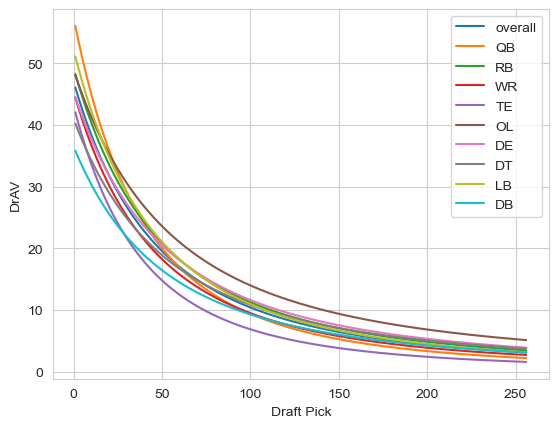

In [79]:
#plt.scatter(picks['Pick'],picks['DrAV'],marker='.')
plt.plot(range(1,257),dravreg.predict(draftpick), label='overall')
plt.plot(range(1,257),QBmodelAv.predict(draftpick), label='QB')
plt.plot(range(1,257),RBmodelAv.predict(draftpick), label='RB')
plt.plot(range(1,257),WRmodelAv.predict(draftpick), label='WR')
plt.plot(range(1,257),TEmodelAv.predict(draftpick), label='TE')
plt.plot(range(1,257),OLmodelAv.predict(draftpick), label='OL')
plt.plot(range(1,257),DEmodelAv.predict(draftpick), label='DE')
plt.plot(range(1,257),DTmodelAv.predict(draftpick), label='DT')
plt.plot(range(1,257),LBmodelAv.predict(draftpick), label='LB')
plt.plot(range(1,257),DBmodelAv.predict(draftpick), label='DB')
plt.xlabel('Draft Pick')
plt.ylabel('DrAV')
plt.legend()

As a bonus result, we can give a table showing the value of a pick in the various rounds for each position. As expected first round quarterbacks are the most valuable.

In [80]:
table=np.array([model.predict([[(i+k)**-0.5 ] for i in [0,16,32,64,96,128,160,250]]) for model in ModelAv])

In [81]:
pd.DataFrame(table, index=["All","QB", "RB", "WR","TE","OL","DE","DT","LB","DB"], columns=[0,16,32,64,96,128,160,250])

,0,16,32,64,96,128,160,250
All,47.086610,34.277692,25.884829,16.075184,10.873789,7.830764,5.913735,3.200436
QB,57.530652,39.281318,28.028844,15.811116,9.883810,6.661523,4.753588,2.272764
RB,49.302837,36.135707,27.452388,17.223358,11.748317,8.520200,6.473167,3.549523
WR,45.423081,32.669944,24.408721,14.886406,9.921106,7.056066,5.272107,2.787362
TE,43.171379,29.320645,20.823326,11.653133,7.237046,4.850905,3.445312,1.630406
OL,48.928377,37.595514,29.779825,20.055556,14.499287,11.041526,8.746517,5.254761
DE,45.416197,34.087369,26.446235,17.194248,12.076619,8.976119,6.964351,3.998412
DT,41.019173,30.996837,24.193303,15.890495,11.254575,8.424039,6.575357,3.824959
LB,52.259251,37.621939,28.131773,17.181117,11.463618,8.161017,6.102743,3.232361
DB,36.533144,27.384038,21.220796,13.769633,9.655614,7.166901,5.554147,3.180662
